This notebook is used to eliminate features, train models and predict results in a pipeline.

We draw correlation matrix to determine the co-relation between features and delete closely related features.
The final data is passed through a pipeline with different estimators which is finally used to predict with a voting classifier.

Cell to pull the repository data from GitHub.

In [0]:
import os
from getpass import getpass
import urllib

cmd_string = 'git clone https://github.com/srivathsa-rao/MOOC-Dropout-Prediction.git MLProject'

os.system(cmd_string)

In [0]:
import numpy as np
import pandas as pd

Cells to read the generated feature data of the train and the test and load it into pandas data frame.

In [0]:
train_features = pd.read_csv('/content/MLProject/submissions/data/train/finalData.csv')
train_truth = pd.read_csv('/content/MLProject/submissions/data/train/truth_train.csv', names=['enrollment_id', 'label'])

test_features = pd.read_csv('/content/MLProject/submissions/data/test/finalData.csv')
test_truth = pd.read_csv('/content/MLProject/submissions/data/test/truth_train.csv', names=['enrollment_id', 'label'])

train_labels = train_truth['label']
test_labels = test_truth['label']

In [0]:
print(train_features.shape)
print(test_features.shape)

(72395, 132)
(24013, 132)


In [0]:
#This data is needed to draw heatmaps used for correlation below.
train = train_features.merge(train_truth, left_on='enrollment_id', right_on='enrollment_id', how='inner')

Drop rate or completion rate is deleted as it introduces bias in the dataset. This resulted in high AUC in the training and the model didn't generalize well. This resulted in having low AUC on training set.
The negative impact on inclusion of this columns can be seen in the report.

The enrollment id is just an identification used in the data to merge different csv's in order to extract data. We have de-identified the data to remove the bias that might cause due to this enrollment id.

In [0]:
del train_features['enrollment_id']
del test_features['enrollment_id']

del train_features['drop_rate']
del test_features['drop_rate']
del train_features['completion_rate']
del test_features['completion_rate']

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


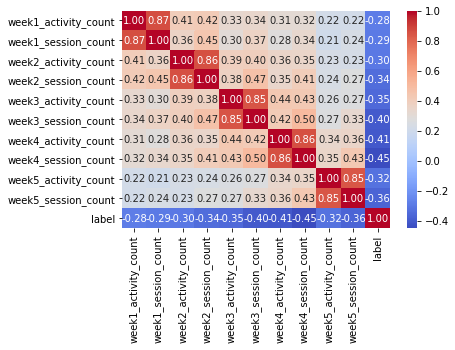

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

week_activity = ['week1_activity_count', 'week1_session_count','week2_activity_count','week2_session_count' ,'week3_activity_count', 'week3_session_count','week4_activity_count', 'week4_session_count','week5_activity_count', 'week5_session_count','label']

cr_map = sns.heatmap(train[week_activity].corr(), annot=True, fmt=".2f", cmap="coolwarm")

**Deletion of week activity count**:
As you can see above the individual week acitivity count is closely correlated to week session count. So, we have removed the week activity count from the data(as week session count is closely related to label than week activity count).

In [0]:
for column in train_features.columns:
  if '_activity_count' in column and 'week' in column:
    del train_features[column]
    del test_features[column]

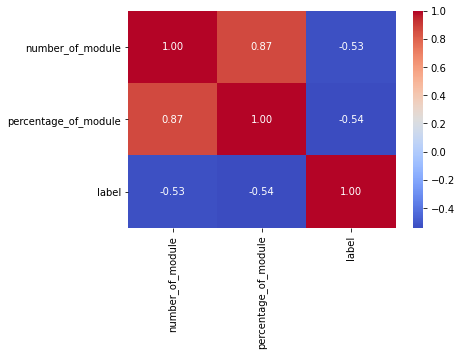

In [0]:
module_data = ['number_of_module','percentage_of_module' ,'label']
cr_map = sns.heatmap(train[module_data].corr(), annot=True, fmt=".2f", cmap="coolwarm")

As you can see above the number of module in a course and the percentage of module are highly correlated. we removed the number_of_module column. We see better results after removal of the number_of_module.

In [0]:
del train_features['number_of_module']
del test_features['number_of_module']

**Deletion of categories of modules which has no events performed**: We have 15 different categories of module for each course. Out of these 15, we have student logs for only 5 categories of modules in log_data. So, we have removed the 10 columns which have values as zero.

In [0]:
zeroFeatureColumns = ['about','course','course_info','html','outlink','static_tab','vertical','peergrading','discussion','dictation']
for column in zeroFeatureColumns:
  del train_features[column]
  del test_features[column]

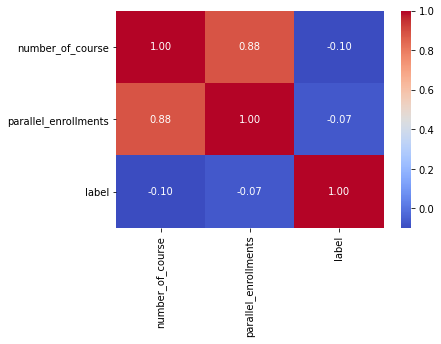

In [0]:
users_course = ['number_of_course','parallel_enrollments', 'label']

cr_map = sns.heatmap(train[users_course].corr(), annot=True, fmt=".2f", cmap="coolwarm")

parallel enrollments of user and number of course taken by user are highly correlated. Based on the correlation of these to labels, we delete parallel enrollments from the data.

In [0]:
del train_features['parallel_enrollments']
del test_features['parallel_enrollments']

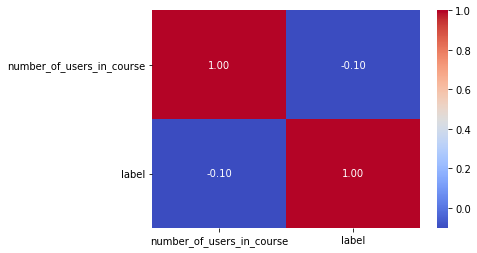

In [0]:
users_course = ['number_of_users_in_course','label']
cr_map = sns.heatmap(train[users_course].corr(), annot=True, fmt=".2f", cmap="coolwarm")

In [0]:
# del train_features['number_of_users_in_course']
# del test_features['number_of_users_in_course']

In [0]:
print(train_features.shape)
print(test_features.shape)

(72395, 112)
(24013, 112)


**Dummy Classifier** - A classic example of imbalanced data.

We have used the dummy classifier from the sklearn on the training data to know the class imbalance in the training data.

auc: 0.5
accuracy: 0.7924027902479454
logloss: 7.170319602029022
Confusion matrix, without normalization
[[    0 15029]
 [    0 57366]]
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


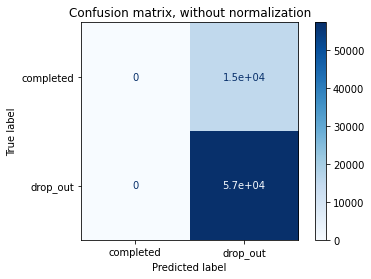

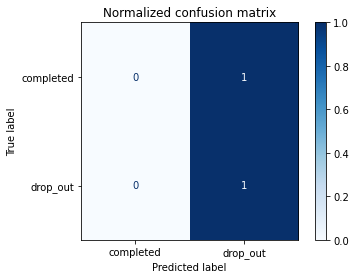

In [0]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, f1_score, accuracy_score,roc_auc_score,log_loss,precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt


dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_features, train_truth.label)

predictions = dummy_clf.predict(train_features)

print('auc: '+str(roc_auc_score(train_truth.label,predictions)))
print('accuracy: '+str(accuracy_score(train_truth.label,predictions)))
print('logloss: '+str(log_loss(train_truth.label,predictions)))

#print(classification_report(test_truth.label, predictions))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(dummy_clf, train_features, train_truth.label,
                                 display_labels=['completed','drop_out'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()



Function to try different sampling techniques like random sampling and SMOTE sampling.

Appropriate attributes would result in the output of training data set accordingly. We do a shuffle at the end to avoid the existence of same class which caused errors when we did cross-validation below.


In [0]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN

def do_sampling(upsampling, train_features, train_truth, smote=False):
  X_train = train_features
  y_train = train_truth.label


  if smote is False:
    X = pd.concat([X_train, y_train], axis=1)
    
    completed = X[X.label==0]
    drop_out = X[X.label==1]

    if upsampling is True:
      sampled = resample(completed, replace=True, n_samples=len(drop_out), random_state=27)
      sampled = pd.concat([drop_out, sampled])
    elif upsampling is False:
      sampled = resample(drop_out, replace=False, n_samples=len(completed), random_state=27) 
      sampled = pd.concat([sampled, completed])
    
    if upsampling is not None:
      sampled = sampled.sample(frac=1).reset_index(drop=True)
      print(sampled.label.value_counts())
      y_train = sampled.label
      X_train = sampled.drop('label', axis=1)
  
  elif smote is True:

    feature_columns = X_train.columns

    if upsampling is True:
      
      upsample = SMOTE()
      #upsample = BorderlineSMOTE()
      #upsample = ADASYN()
      X_train, y_train = upsample.fit_resample(X_train, y_train)
    
    elif upsampling is False:
      
      over = SMOTE(sampling_strategy=0.4)
      under = RandomUnderSampler(sampling_strategy=0.5)
      
      steps = [('o', over), ('u', under)]
      pipeline = Pipeline(steps=steps)

      X_train, y_train = pipeline.fit_resample(X_train, y_train)


    features = pd.DataFrame(data=X_train, columns=feature_columns)
    label = pd.DataFrame(data=y_train, columns=['label'])
    
    X = pd.concat([features, label], axis=1)
    
    #shuffling to avoid errors in cross-validataion. Without this some folds will have data of only one class.
    X = X.sample(frac=1).reset_index(drop=True)
    
    print(X.label.value_counts())
    
    y_train = X.label
    X_train = X.drop('label', axis=1)

  return X_train, y_train

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
# setting up testing and training sets
# smote - False : upsample = True, upsample = False, upsample = None
# To try - upsample = True and upsample = None(gives original imbalanced class)

# smote - True : upsample = True, upsample = False(upsamples minority and downsamples majority)
# To try - upsample = True and upsample = False(upsamples minority and downsamples majority)

smote = True 
upsample = False
X_train, y_train = do_sampling(upsample, train_features, train_truth, smote)
print(X_train.shape)


X_test = test_features
y_test = test_truth.label

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1    45892
0    22946
Name: label, dtype: int64
(68838, 112)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Use decision tree to determine the top features. We have used sns barplot to draw the importance graph of top 14 features.

,active_days,week5_session_count,week4_session_count,time_navigate_server,percentage_of_module,time_access_server,number_of_course,time_page_close_browser,count_problem_browser,week3_session_count,sequential,time_video_browser,count_access_server,time_problem_browser,count_navigate_server,number_of_users_in_course,overall_course_completion_rate,time_access_browser,count_page_close_browser,count_video_browser,time_discussion_server,problem,chapter,video,time_problem_server,count_access_browser,time_wiki_server,count_discussion_server,week1_session_count,day1_activity_count,day21_activity_count,day9_activity_count,day7_activity_count,week2_session_count,count_problem_server,day4_activity_count,day2_activity_count,day3_activity_count,day5_activity_count,day14_activity_count,...,course_q6A6QG7qMpyNcznyT2XaIxnfNGkZRxXl,course_NmbZ3BmS8V4pMg6oxXHWpqqMZCE1jvYt,course_7GRhBDsirIGkRZBtSMEzNTyDr2JQm4xx,course_V4tXq15GxHo2gaMpaJLZ3IGEkP949IbE,course_shM3Yy9vxHn2aqjSYfQXOcwGo0hWh3MI,course_5Gyp41oLVo7Gg7vF4vpmggWP5MU70QO6,course_bWdj2GDclj5ofokWjzoa5jAwMkxCykd6,course_AXUJZGmZ0xaYSWazu8RQ1G5c76ECT1Kd,course_3VkHkmOtom3jM2wCu94xgzzu1d6Dn7or,course_1pvLqtotBsKv7QSOsLicJDQMHx3lui6d,course_a2E7NQC7nZB7WHEhKGhKnKvUWtsLAQzh,course_9Bd26pfDLvkPINwLnpaGcf0LrLUvY1Mz,course_X78EhlW2JxwO1I6S3U4yZVwkEQpKXLOj,course_9Mq1P5hrrLw6Bh9X4W4ZjisQJDdxjz9x,course_nSfGxfEtzw5G72fVbfaowxsV46Pg1xIc,course_Er0RFawC4sHagDmmQZcBGBrzamLQcblZ,course_TAYxxh39I2LZnftBpL0LfF2NxzrCKpkx,course_9zpXzW9zCfU8KGBWkhlsGH8B8czISH4J,course_HbeAZjZFFQUe90oTP0RRO0PEtRAqU3kK,course_RXDvfPUBYFlVdlueBFbLW0mhhAyGEqpt,course_gvEwgd64UX4t3K7ftZwXiMkFuxFUAqQE,course_Wm3dddHSynJ76EJV6hyLYKGGRL0JF3YK,course_tXbz2ZYaRyb2ZsWUBPoYzAmisOhHQrYl,course_G8EPVSXsOYB5YQWZGiz1aVq5Pgr2GrQu,course_5X6FeZozNMgE2VRi3MJYjkkFK8SETtu2,course_KHPw0gmg1Ad3V07TqRpyBzA8mRjj7mkt,course_mTmmr5zd8l4wXhwiULwjSmSbi9ktcFmV,course_fbPkOYLVPtPgIt0MxizjfFJov3JbHyAi,course_WM572q68zD5VW8pcvVTc1RhhFUq3iRFN,combinedopenended,count_wiki_browser,count_video_server,count_page_close_server,count_navigate_browser,time_wiki_browser,time_discussion_browser,time_video_server,time_page_close_server,time_navigate_browser,count_discussion_browser
0,0.383188,0.077375,0.071525,0.032172,0.023306,0.02132,0.016659,0.016382,0.016275,0.014258,0.014015,0.014008,0.013492,0.012079,0.011943,0.010993,0.010179,0.010025,0.009579,0.009324,0.009248,0.009161,0.007713,0.007218,0.006446,0.00607,0.005942,0.005797,0.005444,0.00491,0.004866,0.004317,0.004264,0.004179,0.004159,0.004034,0.003897,0.003888,0.003855,0.003726,...,0.000949,0.000904,0.000834,0.00083,0.000785,0.000778,0.000737,0.000731,0.000713,0.000678,0.000668,0.00064,0.000585,0.000582,0.00058,0.000575,0.000563,0.000539,0.000525,0.000458,0.000395,0.000358,0.000348,0.000315,0.000286,0.000272,0.000258,0.000221,0.000066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


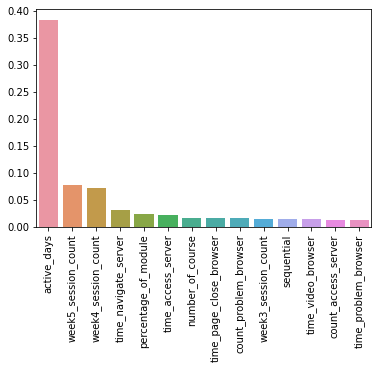

In [0]:
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

tree_classifier=DecisionTreeClassifier().fit(X_train,y_train)

feature_impt=pd.DataFrame(data=tree_classifier.feature_importances_).T
feature_impt.columns=X_train.columns.values


feature_importances=pd.DataFrame()
for column in X_train.columns.values:
    value=feature_impt.filter(regex=column)
    value=value.mean(axis=1)
    feature_importances[column]=value

feature_importances = feature_importances.sort_values(by=0, axis=1, ascending=False)

top_features = feature_importances.iloc[:,0:14]

p=sns.barplot(data=top_features)
p.set_xticklabels(p.get_xticklabels(),rotation=90)

feature_importances


Building the transformer with a pipeline which is used to transform the data.

We don't have any categorical data that is not encoded into numericals left at this point.

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

transformer = Pipeline([
    ('features', FeatureUnion(n_jobs=4, transformer_list=[        
        ('numericals', Pipeline([
            ('selector', TypeSelector(np.number)),
            ('imputer',SimpleImputer()),
            ('scaler', StandardScaler()),
            
        ])) 
    ])), 
]) 

We have put the estimators that are used in the pipeline and have called fit on each one of them. 

Each parameter that is passed to*** individual models is after the hyperparameter tuning.*** This tuning was done using the gridsearch code which is the upcoming cell. 
We have measured the best performance for each model and have updated here to avoid running grid search again.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier


estimators=[
            ('balancedLogistic',LogisticRegression(class_weight='balanced', C=0.01, tol=100, max_iter=1000, random_state=0)),
            ('svm', SVC(class_weight='balanced', C=1, tol=0.01, probability=True, random_state=0)),
            ('randomForest',RandomForestClassifier(n_estimators= 100, n_jobs= -1, max_depth=5, min_samples_split= 5, random_state=0)),
            ('gradientBoosting',GradientBoostingClassifier(learning_rate=0.1, n_estimators=150,max_features='auto', min_samples_split= 2, random_state=0)),
            ('xgboost', XGBClassifier(objective="binary:logistic", learning_rate=0.3, max_depth=4, gamma=0.5, random_state=0)),
            ('neuralNetwork', MLPClassifier(max_iter=1000, activation='relu', alpha=0.0001, hidden_layer_sizes=(100, 150, 100), solver='sgd', random_state=0)),
            ('knn',KNeighborsClassifier(n_neighbors=5,weights='distance',algorithm='auto'))
]


pipes={}
for model in estimators:
    pipe=Pipeline(steps=[('data_prep',transformer),model])
    pipe.fit(X_train,y_train)
    pipes[pipe.steps[1][0]]=pipe

Defined the metrics on which the models will be evaluated.

In [0]:
metrics={'f1':make_scorer(f1_score),'auc':make_scorer(roc_auc_score),
         'accuracy':'accuracy','logloss':make_scorer(log_loss),'balanced_accuracy':make_scorer(balanced_accuracy_score)}

_metrics = metrics
estimator_names=[model[0] for model in estimators]

Plotting the individual models performance after the initial fit with K fold cross validation. Here we have selected 5 folds.

In [0]:
from sklearn.model_selection import KFold,cross_validate
from sklearn.metrics import make_scorer, f1_score, accuracy_score,roc_auc_score,log_loss,precision_score, recall_score, balanced_accuracy_score


def plot_models(estimators=estimator_names,n_splits=5,metrics=['f1','auc','accuracy','logloss', 'balanced_accuracy']):
    metrics={key : _metrics[key] for key in metrics}
    scorers=[]
    labels=[]
    for pipe_name in pipes.keys():
        if pipe_name in estimators:
            pipe=pipes[pipe_name]
            labels.append(pipe_name)
            kf=KFold(n_splits)
            model_score=cross_validate(pipe,X_train,y_train,scoring=metrics,cv=kf)
            scorers.append(model_score)
    
    score_lists={}
    for metric in metrics:
        score_lists[metric]=[score['test_'+metric] for score in scorers]
    
    for  i,(title, _list) in enumerate(score_lists.items()):
        plt.figure(i)
        plot=sns.boxplot(data=_list).set_xticklabels(labels, rotation=45)
        plt.title(title)
    return scorers

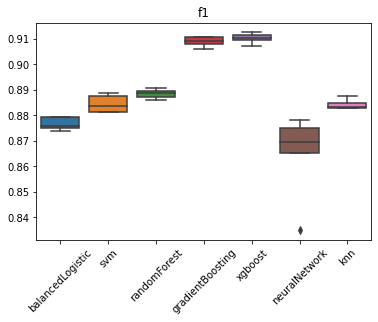

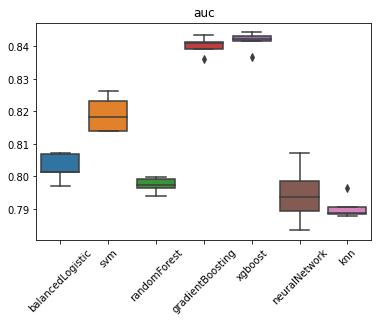

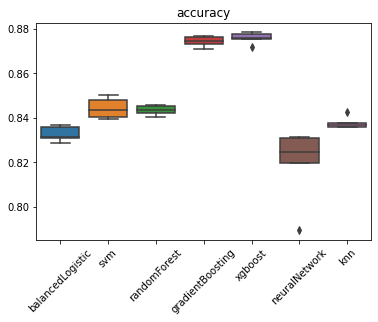

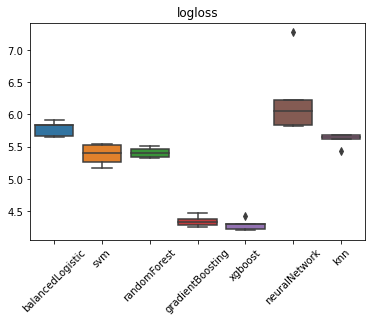

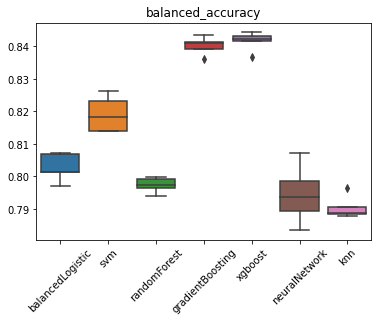

In [0]:
scorers = plot_models(['balancedLogistic', 'svm', 'knn','gradientBoosting', 'neuralNetwork', 'randomForest','xgboost'])

#print(scorers)

Hyper parameter tuning using grid search and drawing heatmaps for related paramteres.

In [0]:

from sklearn.model_selection import GridSearchCV

def hyperparameter_tuning(model,param_grid,refit='auc',chart=None,data=X_train,target=y_train,cv=5):
    
    param_grid={model+'__'+key : param_grid[key] for key in param_grid.keys()}

    gcv=GridSearchCV(pipes[model],param_grid,scoring=metrics,refit=refit,cv=cv)
    gcv.fit(data,target)

    print('Best Score for the model is: '+str(gcv.best_score_))
    print('Best Params for the model is: '+str(gcv.best_params_))
    results=pd.DataFrame(gcv.cv_results_)
               
    if 'heatmap' in chart:
        assert len(param_grid) == 2,  'Works only with 2 params, {} passed'.format(str(len(param_grid)))
        
        param1=list(param_grid.keys())[0]
        param2=list(param_grid.keys())[1]

        graph_data=results[['param_'+param1,'param_'+param2,'mean_test_'+refit]]
        graph_data=graph_data.pivot(index='param_'+param1,columns='param_'+param2,values='mean_test_'+refit)
        sns.heatmap(graph_data,annot=True,xticklabels=True,yticklabels=True).set(xlabel=param2,ylabel=param1)

The below code is commented as this was run for individual models and the best parameters is put in the initial cell to save time.

In [0]:
# pipes['balancedlogistic'].named_steps['balancedlogistic'].get_params()

In [0]:
  # param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
  #           'tol':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}

  # hyperparameter_tuning('balancedlogistic',param_grid,chart='heatmap')

In [0]:
# pipes['balancedlogistic'].set_params(**{'balancedlogistic__C': 0.1, 'balancedlogistic__tol': 1})

In [0]:
# scorers = plot_models(['balancedLogistic', 'svm', 'knn','gradientBoosting', 'neuralNetwork', 'randomForest','xgboost'])

Transforming the input data to be used to plot the learning curve.




In [0]:
pipeline_transformer=transformer
pipeline_transformer.fit(X_train)
transformed_data=pipeline_transformer.transform(X_train)

Code to draw the learning curve for the models to evaluate the overfitting of models.

In [0]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def draw_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel("Number of Training examples")
    plt.ylabel("Scores")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)


    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    minus_value = train_scores_mean - train_scores_std
    plus_value = train_scores_mean + train_scores_std


    plt.fill_between(train_sizes, minus_value, plus_value, alpha=0.1, color="r")
    
    plt.fill_between(train_sizes, minus_value, plus_value, alpha=0.1, color="b")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b", label="Cross-validation score")

    plt.legend(loc="best")
    return plt



/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


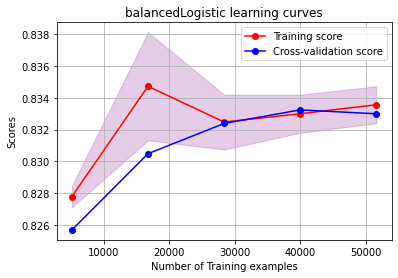

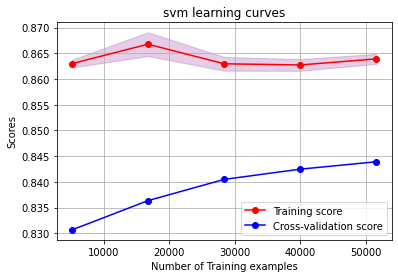

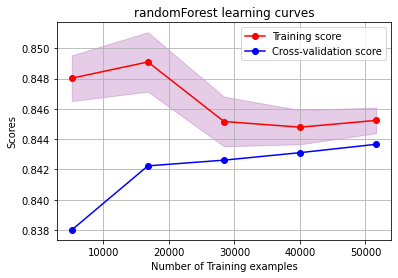

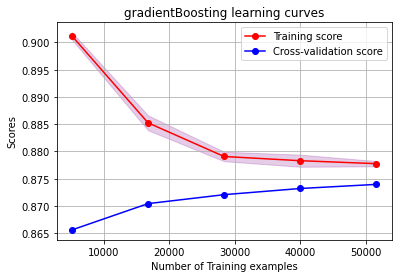

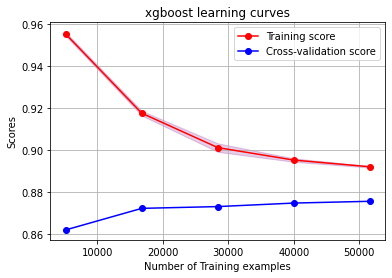

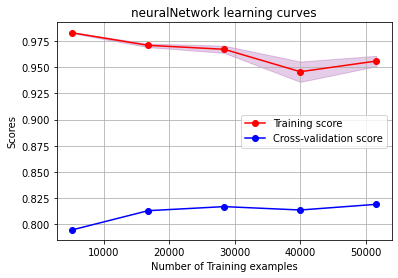

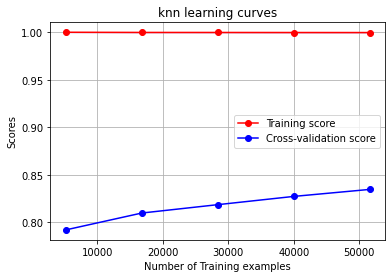

In [0]:

to_plot=['balancedLogistic', 'svm', 'knn','gradientBoosting', 'neuralNetwork', 'randomForest','xgboost']

for name in pipes.keys():
    if name in to_plot:
        g=draw_learning_curve(pipes[name].named_steps[name],name+' learning curves',transformed_data,y_train,cv=KFold(4),n_jobs=4)

Feature importance graph of top 30 features of xgboost and randomForest.

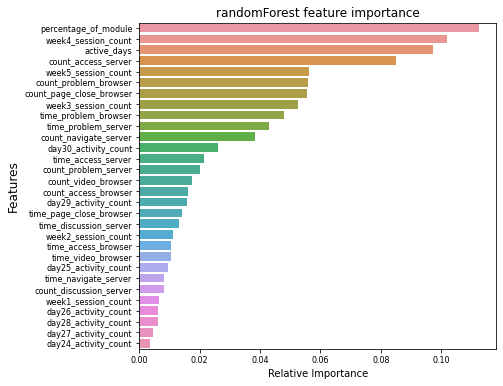

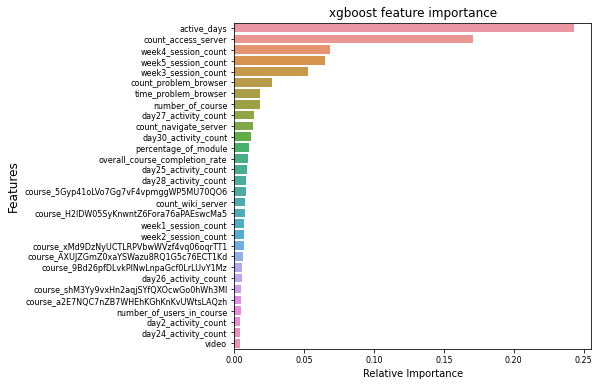

In [0]:

tree_based=['xgboost', 'randomForest']
for name in pipes.keys(): 
    if name in tree_based:
        feat_impt=pipes[name].named_steps[name].feature_importances_
        graph_data=pd.DataFrame()

        graph_data['feature']=X_train.columns.values
        graph_data['importance']=feat_impt
        graph_data_top=graph_data.nlargest(30,'importance')

        plt.figure(figsize=(6.4,6))
        g=sns.barplot(y='feature',x='importance',data=graph_data_top,orient='h')
        g.set_ylabel('Features',fontsize=12)
        g.set_xlabel('Relative Importance')
        g.set_title(name + " feature importance")
        g.tick_params(labelsize=8)
        

Output of individuals models seen in heatmap. This helps in visualizing the variations in results between modules.

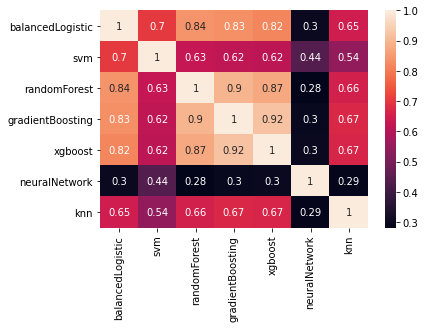

In [0]:
ensemble_results=pd.DataFrame()
for name,pipe in pipes.items():
    ensemble_results[name]=pipe.predict(X_test)
sns.heatmap(ensemble_results.corr(),annot=True)

Delete the pipes which are closely related or add only those models to the estimators which have variance in the results.
This helps in bringing in good results in voting classifier.

In [0]:
# del pipes['neuralNetwork']

In [0]:
pipes['svm'].set_params(**{'svm__probability': True})

In [0]:
from sklearn.base import clone

#probable_estimators = ['balancedLogistic', 'svm', 'gradientBoosting', 'randomForest','xgboost', 'neuralNetwork', 'knn']\
probable_estimators = ['balancedLogistic','gradientBoosting', 'randomForest','xgboost']


estimators = []
for pipe in pipes.values():
  if pipe.steps[1][0] in probable_estimators:
    estimators.append((pipe.steps[1][0],clone(pipe.steps[1][1])))


Function to plot the confusion matrix of the predictions of the individual models or the voting classifier.

In [0]:
import itertools
def plot_confusion_matrix(cm, classes = ['completed', 'drop_out'], normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Print the prediction results of the model and this function calls the classification report and the confusion matrix functions.

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, f1_score, accuracy_score,roc_auc_score,log_loss,precision_score, recall_score, balanced_accuracy_score


def print_predictions(target,predictions, draw_confusion_matrix):
    print('accuracy: '+str(accuracy_score(target,predictions)))
    print('logloss: '+str(log_loss(target,predictions)))

    print(classification_report(target, predictions))

    if draw_confusion_matrix is True:
      class_names = ['completed', 'drop_out']
      cnf_matrix = confusion_matrix(target, predictions)
      np.set_printoptions(precision=2)
      
      plt.figure()
      plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
      
      plt.figure()
      plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
      
      plt.show()

Converting the prediction probability to binary classification outputs.

In [0]:
def convert_pedict_probability(probability):
  predictions = []
  for out in preditct_probability:
    if out[0] > out[1]:
      predictions.append(0)
    else:
      predictions.append(1)
  return predictions

Code to plot the ROC curve to determine the Area under curve.

In [0]:
from sklearn.metrics import roc_curve
def plot_roc_curve(fpr, tpr):
 plt.plot(fpr, tpr, color='orange', label='ROC')
 plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
 plt.xlabel('False Positive Rate')
 plt.ylabel('True Positive Rate')
 plt.title('Receiver Operating Characteristic (ROC) Curve')
 plt.legend()
 plt.show()

In [0]:
for estimator in estimators:
  if estimator[0] is 'svm':
    print(estimator[1].set_params(**{'probability': True}))

Final prediction using the soft voting classifier. This outputs the result in terms of probabilities which is then used to print the metrics.

accuracy: 0.8753175363344855
logloss: 4.306439503758374
              precision    recall  f1-score   support

           0       0.72      0.63      0.67      4902
           1       0.91      0.94      0.92     19111

    accuracy                           0.88     24013
   macro avg       0.82      0.79      0.80     24013
weighted avg       0.87      0.88      0.87     24013

Confusion matrix, without normalization
[[ 3107  1795]
 [ 1199 17912]]
Normalized confusion matrix
[[0.63 0.37]
 [0.06 0.94]]


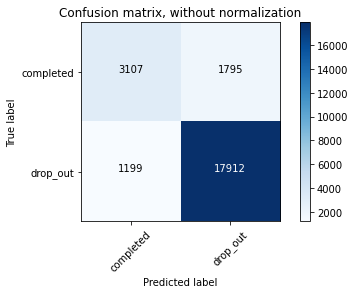

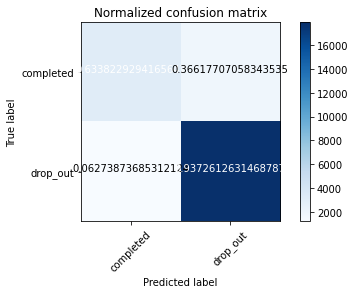

In [57]:
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone

#estimators=[(pipe.steps[1][0],clone(pipe.steps[1][1])) for pipe in pipes.values()] 
vote=Pipeline(steps=[('data_prep',transformer),('voter',VotingClassifier(estimators, voting='soft'))])

vote.fit(X_train,y_train)

preditct_probability = vote.predict_proba(X_test)
predictions = convert_pedict_probability(preditct_probability)

#predictions=vote.predict(X_test)
print_predictions(y_test,predictions, True)

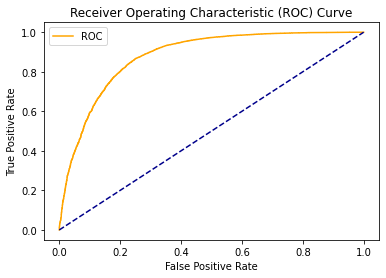

AUC-ROC : 0.8789084378340619


In [58]:
probs = preditct_probability[:, 1]
auc = roc_auc_score(y_test, probs)

fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print("AUC-ROC :",auc)

Grid search code to find the best weights of these models.

In [0]:
# params = {'weights':np.random.randint(9, size=(4, 4)).tolist()}
# grid_Search = GridSearchCV(vote['voter'], param_grid = params, scoring=metrics,refit='auc',cv=5)
# grid_Search.fit(X_train,y_train)
# print(grid_Search.best_score_)

# print('best score: '+str(grid_Search.best_score_))
# print('best params: '+str(grid_Search.best_params_))

Got the below output- 
best score: 0.8436000720255248
best params: {'weights': [2, 1, 3, 4]}


In [0]:
vote['voter'].set_params(**{'weights': [2, 1, 3, 4]})

accuracy: 0.8759005538666556
logloss: 4.286304290013968
              precision    recall  f1-score   support

           0       0.73      0.62      0.67      4902
           1       0.91      0.94      0.92     19111

    accuracy                           0.88     24013
   macro avg       0.82      0.78      0.80     24013
weighted avg       0.87      0.88      0.87     24013

Confusion matrix, without normalization
[[ 3062  1840]
 [ 1140 17971]]
Normalized confusion matrix
[[0.62 0.38]
 [0.06 0.94]]


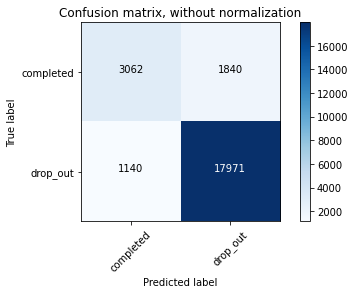

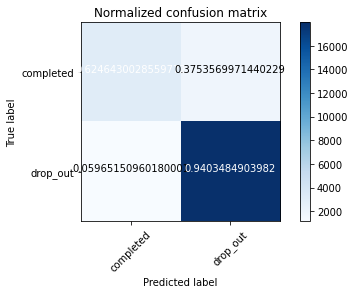

In [60]:
preditct_probability = vote.predict_proba(X_test)
predictions = convert_pedict_probability(preditct_probability)

#predictions=vote.predict(X_test)
print_predictions(y_test,predictions, True)

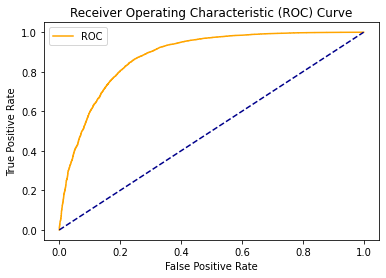

AUC-ROC : 0.879464018759097


In [61]:
probs = preditct_probability[:, 1]
auc = roc_auc_score(y_test, probs)

fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print("AUC-ROC :",auc)

Print the result of individual models on the test data.

=================balancedLogistic==============


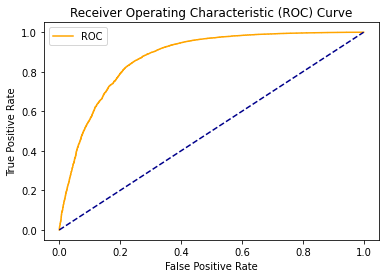

AUC-ROC : 0.8716231096900217
accuracy: 0.858909757214842
logloss: 4.873135360397304
              precision    recall  f1-score   support

           0       0.64      0.69      0.67      4902
           1       0.92      0.90      0.91     19111

    accuracy                           0.86     24013
   macro avg       0.78      0.80      0.79     24013
weighted avg       0.86      0.86      0.86     24013

=================svm==============
=================randomForest==============


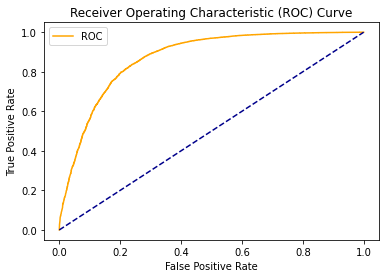

AUC-ROC : 0.870856853562732
accuracy: 0.8719443634697872
logloss: 4.422946931477555
              precision    recall  f1-score   support

           0       0.71      0.62      0.66      4902
           1       0.91      0.94      0.92     19111

    accuracy                           0.87     24013
   macro avg       0.81      0.78      0.79     24013
weighted avg       0.87      0.87      0.87     24013

=================gradientBoosting==============


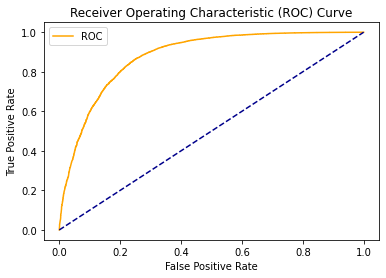

AUC-ROC : 0.8792901435345369
accuracy: 0.8766917919460292
logloss: 4.258979024976493
              precision    recall  f1-score   support

           0       0.74      0.61      0.67      4902
           1       0.90      0.95      0.92     19111

    accuracy                           0.88     24013
   macro avg       0.82      0.78      0.80     24013
weighted avg       0.87      0.88      0.87     24013

=================xgboost==============


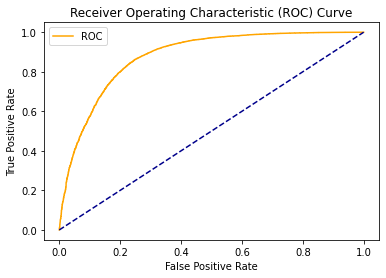

AUC-ROC : 0.8773600314049248
accuracy: 0.8764835713988256
logloss: 4.266171606957303
              precision    recall  f1-score   support

           0       0.75      0.60      0.66      4902
           1       0.90      0.95      0.92     19111

    accuracy                           0.88     24013
   macro avg       0.82      0.77      0.79     24013
weighted avg       0.87      0.88      0.87     24013

=================neuralNetwork==============


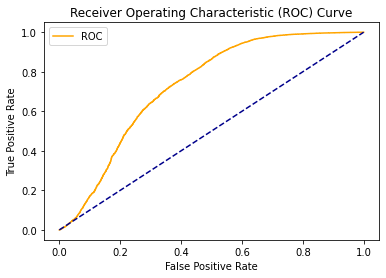

AUC-ROC : 0.728592083983751
accuracy: 0.5841835672344147
logloss: 14.361830451160726
              precision    recall  f1-score   support

           0       0.30      0.76      0.43      4902
           1       0.90      0.54      0.67     19111

    accuracy                           0.58     24013
   macro avg       0.60      0.65      0.55     24013
weighted avg       0.77      0.58      0.62     24013

=================knn==============


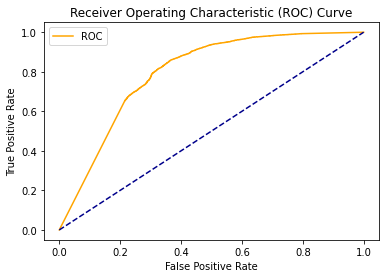

AUC-ROC : 0.7959921264379558
accuracy: 0.8471244742431183
logloss: 5.280214182796744
              precision    recall  f1-score   support

           0       0.66      0.51      0.57      4902
           1       0.88      0.93      0.91     19111

    accuracy                           0.85     24013
   macro avg       0.77      0.72      0.74     24013
weighted avg       0.84      0.85      0.84     24013



In [65]:
for name in pipes.keys():
    print("================={}==============".format(name))

    if 'svm' in name:
      continue
    
    preditct_probability = pipes[name].predict_proba(X_test)
    predictions = convert_pedict_probability(preditct_probability)
    
    preditct_probability = preditct_probability[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, preditct_probability)

    auc = roc_auc_score(y_test, preditct_probability)

    plot_roc_curve(fpr, tpr)
    print("AUC-ROC :",auc)

    print_predictions(y_test,predictions, False)